## Names

### Spencer Bernardo-Cheng, Robbie Keehan, Max Goldstein


## Selecting The Evaluation Metric

Our team chose a dataset including over 27,000 images of thin-blood smear slide images. The dataset is perfectly balanced between 13779 images of parasitized cells and 13,779 uninfected cells. These cell images were taken, collected, and organized from 150 P. falciparum-infected and 50 healthy patients located at Chittagong Medical College Hospital, Bangladesh, as part of an initiative to reduce the hassle for microscopists in areas of limited resources and improve diagnostic accuracy. Researchers at Lister Hill National Center for Biomedical Communications (LHNCBC), part of National Library of Medicine (NLM), started this initiative through their development of a smartphone app that can be connected to a conventional microscope. Each blood smear slide image was obtained through the use of this application and labeled by a slide reader at Mahidol-Oxford Tropical Medicine Research Unit in Bangkok, Thailand.

Our prediction task is to classify if a cell is parasitized or uninfected to speed up the process of diagnosing malaria. This classifier would provide great benefits to microscope technicians by reducing the workload of diagnosing malaria. The process for checking for malaria suggested by the WHO is to manually check 5000 cells. We believe that with this large of a sample size that we only need to measure the accuracy of our model. An accuracy of 95% would be good enough to help automate the process becuase of the large sample size. This would end up with around 250 mislabeled and 4,750 correctly labeled cells. This high accuracy could greatly increase the speed of the process and lessen the work load of the technicians.

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
# confirm Keras sees the GPU (for TensorFlow 1.X + Keras)
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0
print(backend.tensorflow_backend._get_available_gpus())





['/job:localhost/replica:0/task:0/device:GPU:0']


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14935370678968559064
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3517906334556125777
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9199368801360181300
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7511012148
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4501728351632726947
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
]


In [4]:
import pandas as pd
import numpy as np
import glob
import cv2
# stack overflow example taken from: https://stackoverflow.com/questions/37747021/create-numpy-array-of-images
X_data = []
y = []

files = glob.glob ("../.././cell_images/Parasitized/*.png")
for myFile in files:
    image = cv2.imread(myFile,cv2.IMREAD_COLOR)
    image = cv2.resize(image,(128,128))
    X_data.append(image)
    y.append((int)(1))
files = glob.glob ("../.././cell_images/Uninfected/*.png")
for myFile in files:
    image = cv2.imread(myFile,cv2.IMREAD_COLOR)
    image = cv2.resize(image,(128,128))
    X_data.append (image)
    y.append((int)(0))
npArr =np.array(X_data)
print('X_data shape:', np.array(X_data).shape)

X_data shape: (27558, 128, 128, 3)


In [5]:
print(npArr[0].shape)
print(npArr[1].shape)
pixels = npArr
pixels.shape

(128, 128, 3)
(128, 128, 3)


(27558, 128, 128, 3)

In [6]:
y = np.array(y)
h=128
w=128
print(y)

[1 1 1 ... 0 0 0]


In [7]:
from matplotlib import pyplot as plt

# a helper plotting function

# def plot_gallery(images, titles, h, w,n_row=3, n_col=6):
#     """Helper function to plot a gallery of portraits"""
#     plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
#     plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
#     for i in range(n_row * n_col):
#         plt.subplot(n_row, n_col, i + 1)
#         plt.imshow(images[i])
#         plt.title(titles[i], size=12)
#         plt.xticks(())
#         plt.yticks(())
#     plt.show()
# plot_gallery(x_train, y_train, h, w) # defaults to showing a 3 by 6 subset of the faces
print(y[0])
plt.imshow(pixels[0])
plt.show()

1


<Figure size 640x480 with 1 Axes>

# Splitting the Data 

We used an 80/20 split as our original data had about 28,000 cell images and we expanded our training set by about 22,000. The data had an even split of the infected and uninfected cells. We believe that a simple 80/20 split would give a large enough validation set to represent the whole dataset.

In [8]:
from sklearn.model_selection import train_test_split
import keras.utils
from keras import utils as np_utils
x_train,x_test,y_train,y_test = train_test_split(pixels, y, test_size = 1/5, random_state = 1)
NUM_CLASSES = 2
x_train = x_train/255.0 - 0.5
x_test = x_test/255.0 - 0.5

(4000, 128, 128, 3)
(4000, 2)


# Data Expansion

We added a rotation range of 360 degrees because the cells did not have a specific orientation. We allowed horizontal and vertical image shifts of 5 percent because this shift would not remove any part of the cell from the image. We also included horizontal and vertical flips as orientation has no affect on the classification task.

In [9]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=360, # used, Int. Degree range for random rotations.
    width_shift_range=0.05, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.05, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None)
datagen.fit(x_train)

In [10]:
tmps = datagen.flow(x_train, y_train, batch_size=len(x_train))
for tmp in tmps:
    x_train = np.concatenate((x_train,tmp[0]))
    y_train = np.concatenate((y_train,tmp[1]))
    break
print(x_train.shape)

(44092, 128, 128, 3)


In [11]:
x_train_flat = []
x_test_flat = []
for val in x_train:
    x_train_flat.append(np.ravel(val))
x_train_flat = np.array(x_train_flat)
for val in x_test:
    x_test_flat.append(np.ravel(val))
x_test_flat = np.array(x_test_flat)

# Xception Style CNN

In [17]:
# Xception style architecture
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.layers import average, concatenate
from keras.models import Input, Model

l2_lambda = 0.000001



input_holder = Input(shape=(128, 128, 3))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (128,128,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = (128,128,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = (128,128,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1,activation="sigmoid")(x)

xception = Model(inputs=input_holder,outputs=x)

xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 32)   9248        max_pooling2d_7[0][0]            
__________________________________________________________________________________________________
max_poolin

In [18]:

# speed up by training by not using augmentation, perhaps there are faster ways??
xception.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

xception_history = xception.fit(x_train, y_train, batch_size=64,
            epochs=10, verbose=1,
            validation_data=(x_test,y_test),
            shuffle=True,
            callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
            )

Train on 44092 samples, validate on 5512 samples
Epoch 1/10
44092/44092 [==============================] - 40s 908us/step - loss: 0.3115 - acc: 0.8742 - val_loss: 0.1647 - val_acc: 0.9465
Epoch 2/10
44092/44092 [==============================] - 39s 879us/step - loss: 0.1604 - acc: 0.9495 - val_loss: 0.1459 - val_acc: 0.9534
Epoch 3/10
44092/44092 [==============================] - 39s 878us/step - loss: 0.1433 - acc: 0.9551 - val_loss: 0.1360 - val_acc: 0.9541
Epoch 4/10
44092/44092 [==============================] - 39s 881us/step - loss: 0.1332 - acc: 0.9572 - val_loss: 0.1310 - val_acc: 0.9545
Epoch 5/10
44092/44092 [==============================] - 39s 877us/step - loss: 0.1248 - acc: 0.9586 - val_loss: 0.1326 - val_acc: 0.9554
Epoch 6/10
44092/44092 [==============================] - 39s 879us/step - loss: 0.1190 - acc: 0.9604 - val_loss: 0.1306 - val_acc: 0.9539
Epoch 7/10
44092/44092 [==============================] - 39s 879us/step - loss: 0.1107 - acc: 0.9618 - val_loss: 0.1

## Xception Results

Xception surpassed our goal of achieving a 95% validation accuracy after training over 10 epochs. This model performed the best out of the three different architectures we tried implementing. Unlike other models, Xception managed to reach the 10th epoch before having to stop with early stopping at a patience level of two. 

## Plotting Xception Training/Validation Loss & Accuracy Graphs

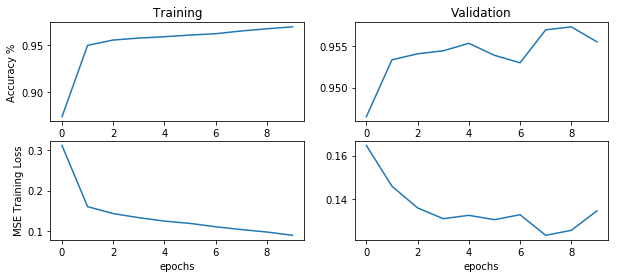

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(xception_history.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(xception_history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(xception_history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(xception_history.history['val_loss'])
plt.xlabel('epochs')
plt.show()

## Custom Style CNN

This model included three layers of 2D convolutions with the latter two layers having maxpooling in between each layer. We incorporated dropout twice and utilized a sigmoid activation function

In [24]:
cnn2 = Sequential()
cnn2.add( Conv2D(filters=16, 
                kernel_size=(3,3), 
                input_shape = (128,128,3),
                padding='same', 
                activation='linear',data_format="channels_last") ) # more compact syntax

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',data_format="channels_last") ) # more compact syntax

    # max pooling
    cnn2.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_last") )
    

# add one layer on flattened output
cnn2.add(Dropout(0.25))
cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dropout(0.5))
cnn2.add(Dense(64, activation='relu'))
cnn2.add(Dense(1, activation='sigmoid'))

# Let's train the model 
cnn2.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])
cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 65536)             0         
__________

Train on 44092 samples, validate on 5512 samples
Epoch 1/10
44092/44092 [==============================] - 59s 1ms/step - loss: 0.3117 - acc: 0.8873 - val_loss: 0.1989 - val_acc: 0.9445
Epoch 2/10
44092/44092 [==============================] - 58s 1ms/step - loss: 0.1856 - acc: 0.9449 - val_loss: 0.1492 - val_acc: 0.9534
Epoch 3/10
44092/44092 [==============================] - 58s 1ms/step - loss: 0.1621 - acc: 0.9510 - val_loss: 0.1391 - val_acc: 0.9525
Epoch 4/10
44092/44092 [==============================] - 58s 1ms/step - loss: 0.1571 - acc: 0.9521 - val_loss: 0.1425 - val_acc: 0.9526
Epoch 5/10
44092/44092 [==============================] - 58s 1ms/step - loss: 0.1533 - acc: 0.9543 - val_loss: 0.1470 - val_acc: 0.9492


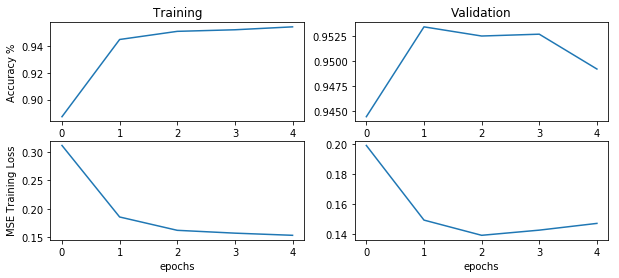

In [25]:
history = cnn2.fit(x_train, y_train, 
        batch_size=64, epochs=10, 
        shuffle=True, verbose=1,
        validation_data=(x_test,y_test),
        callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.show()

## Custom CNN Results

Our custom cnn also managed to achieve 95% accuracy but needed to be stopped early at epoch 5 as the validation loss began to increase. This increase in validation loss would tend to indicate that the model began to overtrain on the training set. 

## Alexnet style CNN

In [26]:
%%time


cnn = Sequential()
# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                kernel_size=(3,3),
                input_shape = (128,128,3),
                padding='same', 
                activation='linear',data_format="channels_last")) # more compact syntax
# cnn.add(MaxPooling2D(pool_size=(2, 2)))
# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu',data_format="channels_last")) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

# Let's train the model 
cnn.compile(optimizer='adam',
              loss='binary_crossentropy', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               33554560  
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
__________

Train on 44092 samples, validate on 5512 samples
Epoch 1/10
44092/44092 [==============================] - 117s 3ms/step - loss: 0.4931 - acc: 0.7848 - val_loss: 0.2083 - val_acc: 0.9289
Epoch 2/10
44092/44092 [==============================] - 112s 3ms/step - loss: 0.2335 - acc: 0.9303 - val_loss: 0.2152 - val_acc: 0.9271
Epoch 3/10
44092/44092 [==============================] - 112s 3ms/step - loss: 0.2200 - acc: 0.9309 - val_loss: 0.1846 - val_acc: 0.9430
Epoch 4/10
44092/44092 [==============================] - 112s 3ms/step - loss: 0.1856 - acc: 0.9412 - val_loss: 0.2134 - val_acc: 0.9307
Epoch 5/10
44092/44092 [==============================] - 112s 3ms/step - loss: 0.1933 - acc: 0.9341 - val_loss: 0.1980 - val_acc: 0.9341


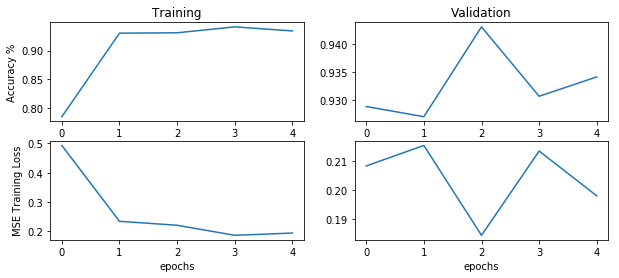

In [27]:
# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
# cnn.fit(x_train, y_train, 
#         batch_size=32, epochs=30, verbose=1,
#         validation_data=(x_test,y_test),
#         callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
history =  cnn.fit(x_train, y_train, 
        batch_size=64, epochs=10, 
        shuffle=True, verbose=1,
        validation_data=(x_test,y_test),
        callbacks=[EarlyStopping(monitor='val_loss', patience=2)]        
        )
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.show()

## Alexnet Results

The Alexnet style architecture did not reach 95% accuracy and is therefore not a reliable enough model based on our evaluation criteria. The model stopped early at epoch 5 due to the validation loss inreasing for two epochs in a row. Similar to the Custom CNN, it can be assumed that the model began to overfit the training data. 

## Alexnet vs Custom CNN McNemar Test

In [28]:
case1 = 0.0 # both models are correct
case2 = 0.0 # MLP correct, NN incorrect
case3 = 0.0 # NN correct, MPL incorrect
case4 = 0.0 # Both incorrect
yhat1 = np.round(cnn.predict(x_test))
yhat2 = np.round(cnn2.predict(x_test))
for i, value in enumerate(y_test):
    if ((value == yhat1[i]) and (value == yhat2[i])):
        case1 += 1
    elif ((value == yhat1[i]) and (value != yhat2[i])):
        case2 += 1
    elif ((value != yhat1[i]) and (value == yhat2[i])):
        case3 += 1
    elif ((value != yhat1[i]) and (value != yhat2[i])):
        case4 += 1
    else:
        print(value, yhat2[i], yhat1[i])
case1 /= 6
case2 /= 6
case3 /= 6
case4 /= 6
print("McNemar test between Alexnet and Custom CNN")
print(np.round(case1), " | ", np.round(case2))
print(np.round(case3), " | ", np.round(case4))

McNemar test between Alexnet and Custom CNN
842.0  |  16.0
30.0  |  31.0


## Alexnet vs Custom CNN ROC Curve

[0.99534273 0.8753073  0.99999976 ... 0.02230284 0.9990611  0.01803198]
[1 1 1 ... 0 1 0]


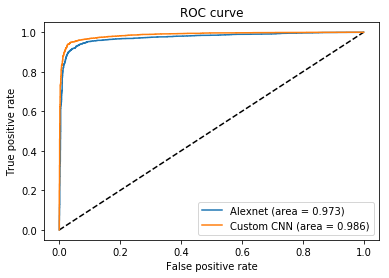

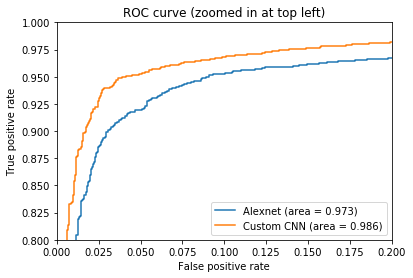

In [29]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn import metrics
yhat1prob = cnn.predict(x_test)
yhat2prob = cnn2.predict(x_test)
print(yhat1prob.ravel())
print(y_test)
fpr_keras, tpr_keras, thresholds = metrics.roc_curve(y_test, yhat1prob.ravel(), pos_label=1)
auc_keras = auc(fpr_keras, tpr_keras)
fpr_keras2, tpr_keras2, thresholds2 = metrics.roc_curve(y_test, yhat2prob.ravel(), pos_label=1)
auc_keras2 = auc(fpr_keras2, tpr_keras2)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Alexnet (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras2, tpr_keras2, label='Custom CNN (area = {:.3f})'.format(auc_keras2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Alexnet (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras2, tpr_keras2, label='Custom CNN (area = {:.3f})'.format(auc_keras2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## Alexnet vs Custom CNN Analysis

After interpreting the Mcnemar Test, the Custom CNN performed relatively the same as the Alexnet Style Architecture given that there is only a difference of 14 between the Case 2 and Case 3 results of the McNemar test. 

Taking a look at the ROC Curve, it is clear to see that the Custom CNN has performed better as the curve bows further outward than the Alexnet style model

## Custom CNN vs Xception

In [67]:
case1 = 0.0 # both models are correct
case2 = 0.0 # MLP correct, NN incorrect
case3 = 0.0 # NN correct, MPL incorrect
case4 = 0.0 # Both incorrect
yhat1 = np.round(xception.predict(x_test))
yhat2 = np.round(cnn2.predict(x_test))
for i, value in enumerate(y_test):
    if ((value == yhat1[i]) and (value == yhat2[i])):
        case1 += 1
    elif ((value == yhat1[i]) and (value != yhat2[i])):
        case2 += 1
    elif ((value != yhat1[i]) and (value == yhat2[i])):
        case3 += 1
    elif ((value != yhat1[i]) and (value != yhat2[i])):
        case4 += 1
    else:
        print(value, yhat2[i], yhat1[i])
case1 /= 6
case2 /= 6
case3 /= 6
case4 /= 6
print("McNemar test between Xception and Custom CNN")
print(np.round(case1), " | ", np.round(case2))
print(np.round(case3), " | ", np.round(case4))

McNemar test between Xception and Custom CNN
863.0  |  15.0
9.0  |  32.0


[0.99364066 0.98426354 0.9999987  ... 0.00563821 0.99993527 0.01849025]
[1 1 1 ... 0 1 0]


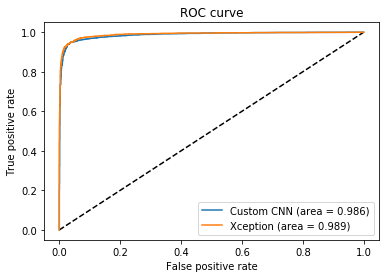

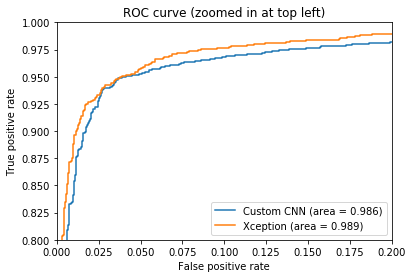

In [68]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn import metrics
yhat1prob = cnn2.predict(x_test)
yhat2prob = xception.predict(x_test)
print(yhat1prob.ravel())
print(y_test)
fpr_keras, tpr_keras, thresholds = metrics.roc_curve(y_test, yhat1prob.ravel(), pos_label=1)
auc_keras = auc(fpr_keras, tpr_keras)
fpr_keras2, tpr_keras2, thresholds2 = metrics.roc_curve(y_test, yhat2prob.ravel(), pos_label=1)
auc_keras2 = auc(fpr_keras2, tpr_keras2)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Custom CNN (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras2, tpr_keras2, label='Xception (area = {:.3f})'.format(auc_keras2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Custom CNN (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras2, tpr_keras2, label='Xception (area = {:.3f})'.format(auc_keras2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## Xception vs Custom CNN Analysis

After interpreting the Mcnemar Test, the Custom CNN performed relatively the same as the Xception Style Architecture given that there is only a difference of 14 between the Case 2 and Case 3 results of the McNemar test. 

Taking a look at the ROC Curve, Xception has performed better as the curve bows further outward than the Custom CNN style model, but the difference in the two curves is very minor although Xception does performs better. 

# MLP Implementation - 6 layer

In [55]:
%%time

# print(x_train_flat.shape[1])
# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=x_train_flat.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(1) )
mlp.add( Activation('sigmoid') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])



mlp.fit(x_train_flat, y_train, 
        batch_size=128, epochs=15, 
        shuffle=True, verbose=1,
       validation_data=(x_test_flat,y_test),
        callbacks=[EarlyStopping(monitor='val_loss', patience=2)]   )


Train on 44092 samples, validate on 5512 samples
Epoch 1/15
44092/44092 [==============================] - 22s 490us/step - loss: 0.2229 - acc: 0.6430 - val_loss: 0.2035 - val_acc: 0.6840
Epoch 2/15
44092/44092 [==============================] - 20s 457us/step - loss: 0.2048 - acc: 0.6847 - val_loss: 0.2052 - val_acc: 0.6776
Epoch 3/15
44092/44092 [==============================] - 20s 456us/step - loss: 0.1996 - acc: 0.6952 - val_loss: 0.1925 - val_acc: 0.7041
Epoch 4/15
44092/44092 [==============================] - 20s 457us/step - loss: 0.1946 - acc: 0.7020 - val_loss: 0.2084 - val_acc: 0.6658
Epoch 5/15
44092/44092 [==============================] - 20s 455us/step - loss: 0.1906 - acc: 0.7080 - val_loss: 0.1933 - val_acc: 0.6880
CPU times: user 55.5 s, sys: 51.6 s, total: 1min 47s
Wall time: 1min 42s


In [62]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.round(cnn.predict(X_test))
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.round(mlp.predict(x_test_flat))
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

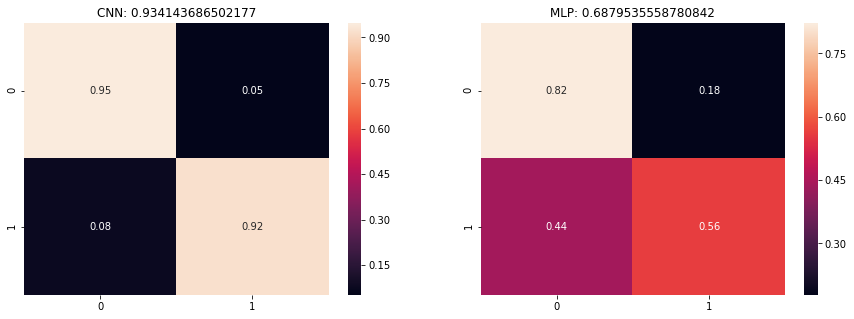

In [63]:
 compare_mlp_cnn(cnn, mlp, x_test, y_test)

## McNemar MLP vs Custom CNN

In [70]:
case1 = 0.0 # both models are correct
case2 = 0.0 # MLP correct, NN incorrect
case3 = 0.0 # NN correct, MPL incorrect
case4 = 0.0 # Both incorrect
yhat1 = np.round(mlp.predict(x_test_flat))
yhat2 = np.round(cnn2.predict(x_test))
for i, value in enumerate(y_test):
    if ((value == yhat1[i]) and (value == yhat2[i])):
        case1 += 1
    elif ((value == yhat1[i]) and (value != yhat2[i])):
        case2 += 1
    elif ((value != yhat1[i]) and (value == yhat2[i])):
        case3 += 1
    elif ((value != yhat1[i]) and (value != yhat2[i])):
        case4 += 1
    else:
        print(value, yhat2[i], yhat1[i])
case1 /= 6
case2 /= 6
case3 /= 6
case4 /= 6
print("McNemar test between MLP and Custom CNN")
print(np.round(case1), " | ", np.round(case2))
print(np.round(case3), " | ", np.round(case4))

McNemar test between MLP and Custom CNN
606.0  |  26.0
266.0  |  20.0


## Comparing MLP to Custom CNN ROC Curve

[0.99534273 0.8753073  0.99999976 ... 0.02230284 0.9990611  0.01803198]
[1 1 1 ... 0 1 0]


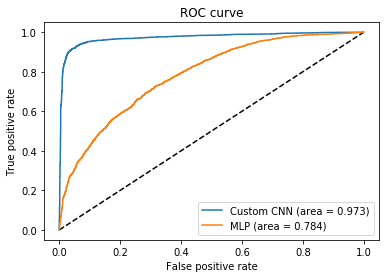

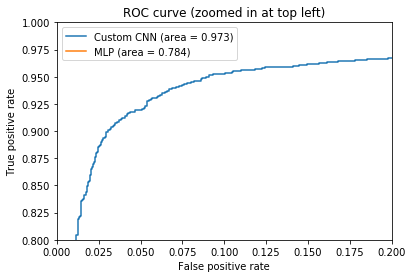

In [66]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn import metrics
yhat1prob = cnn.predict(x_test)
yhat2prob = mlp.predict(x_test_flat)
print(yhat1prob.ravel())
print(y_test)
fpr_keras, tpr_keras, thresholds = metrics.roc_curve(y_test, yhat1prob.ravel(), pos_label=1)
auc_keras = auc(fpr_keras, tpr_keras)
fpr_keras2, tpr_keras2, thresholds2 = metrics.roc_curve(y_test, yhat2prob.ravel(), pos_label=1)
auc_keras2 = auc(fpr_keras2, tpr_keras2)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Custom CNN (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras2, tpr_keras2, label='MLP (area = {:.3f})'.format(auc_keras2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Custom CNN (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras2, tpr_keras2, label='MLP (area = {:.3f})'.format(auc_keras2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# MLP vs Custom CNN Results

The MLP ended up with an accuracy of 68.8%. Upon reviewing the confusion matrix of the MLP, the model tended to guess 0 more often that 1, which in turn, led to a lower accuracy.  This model cannot be used given our evaluation criteria and it performed drastically worse than the custom cnn model. The results of the McNemar tests are clear, showing the custom CNN performed better. The ROC Curve of the Custom CNN bowed outward further than the ROC curve MLP. Given all of these different performance metrics and analysis, the Custom CNN is the better model. 


# Exceptional Work -- Turned in this lab by Sunday, December 1.